#### Importing all the Necessary Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim
import torch.nn as nn

#### Loading the dataset

In [41]:
df = pd.read_csv('/content/Google_Stock_Price_Train-1.csv')

In [42]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [44]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


There are no null values in the dataset.

In [45]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

To make compatable with future numeric operations converted close column to numeric.

In [46]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,109
Volume,0


In [47]:
df_cleaned = df.dropna()

Dropped all the nan values and now the dataset doesn't contain any nan values.

In [48]:
df_cleaned.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


The closing prices are extracted and reshaped to a 2D array, which is needed for scaling. Using MinMaxScaler, normalized the values between 0 and 1. This scaling helps the LSTM model converge faster and perform better.

In [49]:
close_prices_array = df_cleaned['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled_array = scaler.fit_transform(close_prices_array)

The variable sequence_length was set to the number of past prices to incorporate in any given prediction, while step_size would regulate the sequence overlaps. As a result, the repeating loop forms scaled closing prices that have a sequence and appends the subsequent closing price sequence as the input value which is x_sequence and the next price as the output value which is y_value.

In [50]:
sequence_length = 10
step_size = 2
input_sequences = []
output_values = []
for index in range(0, len(close_prices_scaled_array) - sequence_length, step_size):
    x_sequence = close_prices_scaled_array[index:index+sequence_length]
    y_value = close_prices_scaled_array[index+sequence_length]
    input_sequences.append(x_sequence)
    output_values.append(y_value)
input_sequences_tensor = torch.FloatTensor(np.array(input_sequences))
output_values_tensor = torch.FloatTensor(np.array(output_values))

Separated the scaled data into training (80%) and testing data (20%). Both input_sequences_tensor and output_values_tensor are partitioned accordingly into training and testing parts.

In [51]:
train_split = int(len(close_prices_scaled_array) * 0.8)
train_data = close_prices_scaled_array[:train_split]
test_data = close_prices_scaled_array[train_split:]
train_input_sequences = input_sequences_tensor[:len(train_data) // step_size]
train_output_values = output_values_tensor[:len(train_data) // step_size]
test_input_sequences = input_sequences_tensor[len(train_data) // step_size:]
test_output_values = output_values_tensor[len(train_data) // step_size:]

TensorDataset establishes a dataset that links a given input sequence with the value that should be outputted. DataLoader then randomizes the dataset and batches it, easing the process of feeding the model during training.

In [52]:
train_dataset = TensorDataset(train_input_sequences, train_output_values)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

The StockPriceLSTM model incorporates a layer of LSTM neurons which learns how to interpret time series data of the stock prices, combined with a dropout layer to avoid overfitting. A single output node receives the last LSTM output after passing through a blend of a number of such nodes and returns a prediction. The model is defined, together with an optimizer, the mean squared error as a loss function and the Adam optimizer which was used to update model parameters.

In [53]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, output_dim=1, layer_count=3, dropout_rate=0.3):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layer_count, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, inputs):
        lstm_output, _ = self.lstm(inputs)
        predictions = self.fc(lstm_output[:, -1, :])
        return predictions.squeeze()
model_instance = StockPriceLSTM()
loss_function = nn.MSELoss()
optimizer_instance = optim.Adam(model_instance.parameters(), lr=0.001)

Every iteration of the model consists of several epochs which will contain multiple mini-batches of data. For every mini-batch, it makes predictions, determines the loss, does backpropagation, and updates the weight of the model. After each epoch, it provides an average loss so that the training process can be monitored.

In [54]:
epochs = 100
for epoch in range(epochs):
    model_instance.train()
    epoch_loss = 0
    for batch_sequences, batch_labels in train_data_loader:
        optimizer_instance.zero_grad()
        predictions = model_instance(batch_sequences)
        loss = loss_function(predictions, batch_labels.squeeze())
        loss.backward()
        optimizer_instance.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_data_loader)}')

Epoch 1, Loss: 0.1447132108733058
Epoch 2, Loss: 0.06874942942522466
Epoch 3, Loss: 0.05858573317527771
Epoch 4, Loss: 0.039334445260465145
Epoch 5, Loss: 0.010334441147278994
Epoch 6, Loss: 0.0075552965281531215
Epoch 7, Loss: 0.0049309613241348416
Epoch 8, Loss: 0.004501792835071683
Epoch 9, Loss: 0.0043556588352657855
Epoch 10, Loss: 0.0034587462068884633
Epoch 11, Loss: 0.003714510065037757
Epoch 12, Loss: 0.0035846963291987777
Epoch 13, Loss: 0.003302739598439075
Epoch 14, Loss: 0.0035388259711908177
Epoch 15, Loss: 0.003397154447156936
Epoch 16, Loss: 0.0028704843862215057
Epoch 17, Loss: 0.00245473331597168
Epoch 18, Loss: 0.0027313273967592977
Epoch 19, Loss: 0.0030287107510957867
Epoch 20, Loss: 0.002849117881851271
Epoch 21, Loss: 0.002377154251007596
Epoch 22, Loss: 0.0023956457735039294
Epoch 23, Loss: 0.0023801159113645554
Epoch 24, Loss: 0.0023591292338096537
Epoch 25, Loss: 0.0021868540934519842
Epoch 26, Loss: 0.002258869062643498
Epoch 27, Loss: 0.001860078722529579
Ep

Once training is over, changed the model to evaluation state and prepare a tensor of the test sequence. Predictions are made on the test set data without keeping track of gradients and the predictions and actual values are transformed back to the original stock price scale.

In [55]:
model_instance.eval()
test_input_tensor = torch.FloatTensor(test_input_sequences)
with torch.no_grad():
    predicted_values = model_instance(test_input_tensor).numpy().flatten()
predicted_prices = scaler.inverse_transform(predicted_values.reshape(-1, 1))
actual_prices = scaler.inverse_transform(test_output_values.numpy().reshape(-1, 1))

MSE, RMSE and MAE are computed in order to gauge model performance. A smaller value of these metrics is always preferred as they are indicative of prediction accuracy.

In [56]:
mse_score = mean_squared_error(actual_prices.flatten(), predicted_prices.flatten())
rmse_score = np.sqrt(mse_score)
mae_score = mean_absolute_error(actual_prices.flatten(), predicted_prices.flatten())
print(f'MSE: {mse_score}')
print(f'RMSE: {rmse_score}')
print(f'MAE: {mae_score}')


MSE: 101.00471496582031
RMSE: 10.05010986328125
MAE: 7.961521625518799


From the performance metrics of model it is evident that the model is able to capture the general dynamics of the stock prices. Model has MSE equal 101 and RMSE equal 10.05 which suggest that the average difference between the model’s predicted price and the current price of the stocks is around ten dollars and MAE suggests an average absolute deviation of around eight. The existence of these errors indicates that the model has an ability to sustain trends.

The below graph depicts the time series between stock price’s actual and estimated values facilitating the evaluation of the model’s prediction ability.

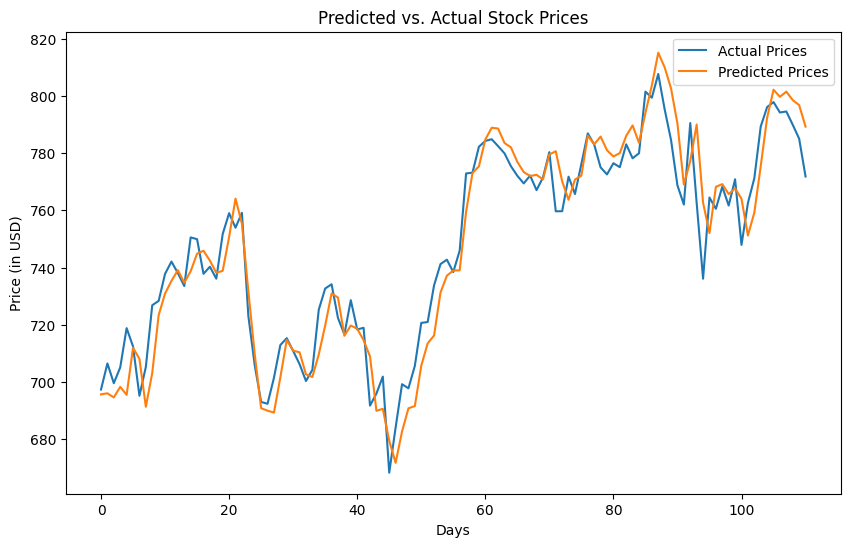

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Predicted vs. Actual Stock Prices')
plt.xlabel('Days')
plt.ylabel('Price (in USD)')
plt.legend()
plt.show()


In the above graph the performance of the model in terms of predicting the stock price through time is shown where the blue line is representing the actual prices whereas the orange line the predicted ones. More often than not, the model manages to capture the trend of the actual stock prices. Practically, there are several areas where the predicted line overlaps with the actual line and these are particularly areas where prices are not changing drastically. Although at the extremes, that is the peaks and the troughs, the predictions are at times off the actual by such a small margin that it is clear the model has issues with drastic short-term price changes. These discrepancies are most likely to be the determinants of the greater error metrics MSE, RMSE and MAE that are noted above and they represent the time lag in the model to the rapid changes in prices. Generally, the model is doing a commendable job in terms of the trends.